# 2. Vulnerability Variables

Impact assessment based on previous research on heatwave and climate risk in Latvia was used to
extract variables indicating socio-economic vulnerability of a population, such as
elderly percentage of total population in a LAU, roma people percentage of total population in a LAU or unemployed percentage of total population in a LAU from Latvian 2000, 2011 and 2021 census datasets. The dataset
(table 1) consists of the open data gathered from the [Central Statistical Bureau of Latvia](https://stat.gov.lv/lv).
Only consistent variables that were found in all three CENSUS datasets were used for variable
selection and data set construction for comparability reasons. For more details of variable selection please see attached text version of the guide.
**<span style="color:red;">[ATTACH LINK!]** </span>


# Importing libraries

In [1]:
# Package for downloading data and managing files
import os

# Packages for handling geospatial maps and data
import geopandas as gpd
import rasterio
import rioxarray
from rasterstats import zonal_stats
from rasterio.enums import Resampling

# Packages for working with numerical data and tables
import pandas as pd
import numpy as np

# Packages for plotting maps
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

#Packages for working with PCA analysis
!pip install factor-analyzer

#Packages for statisticl analysis
! pip install statsmodels

# Local Administrative Units (LAU) map

**[ LAU EUROSTAT map](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units) is outdated for Latvia. Therefore a map of current [Latvian administrative territories](https://data.gov.lv/dati/eng/dataset/administrativo-teritoriju-karte/resource/85aab9e3-a65a-42c0-ab8f-be249f96c58d?inner_span=True) from Latvia's dataset to compose the LAU for the year 2022.**

**This map will be used futher to display social vulnerability variables and social vulnerability indices. Run the code to see the map.**

Output directory already exists.


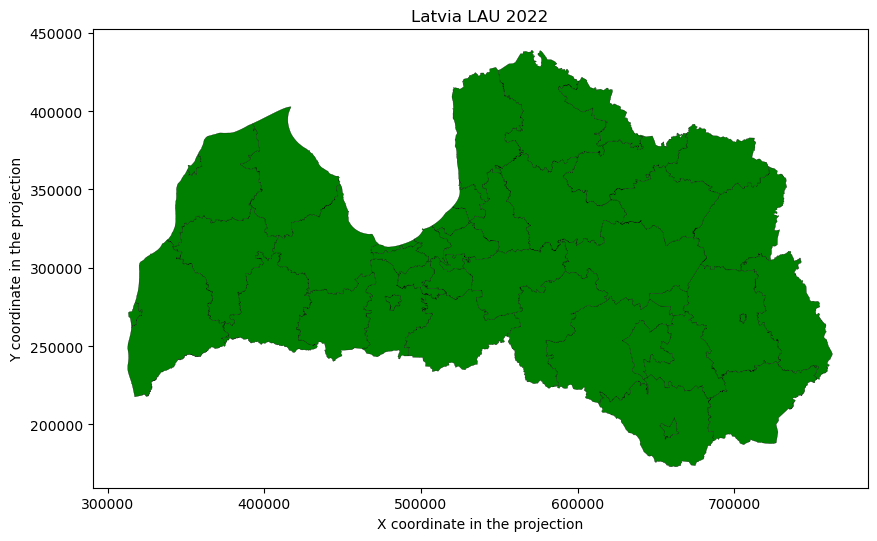

In [2]:
# Relative paths from the notebook's directory
municipalities_path = os.path.join("input files", "Administrative territories", "novadi", "Novadi.shp")
cities_path = os.path.join("input files", "Administrative territories", "pilsetas", "Pilsetas.shp")

# Checking if the paths exist
for path in [municipalities_path, cities_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The required file does not exist: {path}")

# Checking if an output directory exists, and if not, creating it
output_dir = os.path.join("output")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print("Output directory created.")
else:
    print("Output directory already exists.")

# Opening Latvia's regions map
municipalities = gpd.read_file(municipalities_path)
cities = gpd.read_file(cities_path)

#Creating LAU 2022 dataset based on the data described in the link above
cities_LAU = ["Rīga", "Daugavpils", "Jelgava", "Jūrmala", "Liepāja", "Rēzekne", "Ventspils"]
cities_LAU_2022 = cities[cities['LABEL'].isin(cities_LAU)]

#THE MAP
#Combining LAU cities and LAU municipalities to have one map
LV_LAU_2022 = pd.concat([cities_LAU_2022, municipalities], ignore_index=True)

#THIS PART PLOTS THE MAP
fig, ax = plt.subplots(figsize=(10, 10))
LV_LAU_2022.plot(ax=ax, facecolor='green', edgecolor='k', linewidth=0.2)
ax.set_title('Latvia LAU 2022')
ax.set_xlabel('X coordinate in the projection'); ax.set_ylabel('Y coordinate in the projection')

plt.show()

# #displays the dataframe
# # display(LV_LAU_2022.head())

# Vulnerability variables

**Run this code to import vulnerability variables' dataset.**

In [5]:
# Relative path from the notebook's directory
variables_path = os.path.join("input files", "social vulnerability variables.csv")

# Checking if the new dataset path exists
if not os.path.exists(variables_path):
    raise FileNotFoundError(f"The required file does not exist: {variables_path}")

# Reading the new dataset into a pandas DataFrame
variables_df = pd.read_csv(variables_path)

# Creates a list of unique values from the 'variable' column
unique_variables = variables_df['variable'].unique()

# A dictionary to hold dataframes for each variable
variables_dfs = {}
for variable in unique_variables:
    variables_dfs[variable] = variables_df[variables_df['variable'] == variable]

# Dictionary to hold the merged vulnerability and LAU geodataframes
variables_gdfs = {}
for variable, variable_df in variables_dfs.items():
    variable_gdf = LV_LAU_2022.merge(variable_df, left_on='LABEL', right_on='LAU 2022', how='left')
    variables_gdfs[variable] = variable_gdf

# A list to store the year column names
years = []
for col in variables_df.columns:
    if col.isnumeric():
        years.append(col)

![image.png](attachment:1a046299-0c6b-4adf-ad94-80970d1632b8.png)
![image.png](attachment:71100522-2cef-4f32-9412-b5b47fa02a2f.png)

**<span style="color:red;">[I WILL ADD THE NEW UPDATED AND PRETTY TABLE AFTER I FINISH THE TEXT VERSION OF THE GUIDE]** </span>

**Run the code to plot spatial distribuiton of each variable for each year. The code takes some time to run, it can take up to 5 minutes.**

**Each year's each variable's legend has its own min and max value.
The value units can be found in the table above.**

**The vairables that are positively directed towards increase of vulnerability are plotted in the red color,  such as elderly, and variables that are negatively directed towards increase of vulnerability in blue, such as having piped water in a house.**

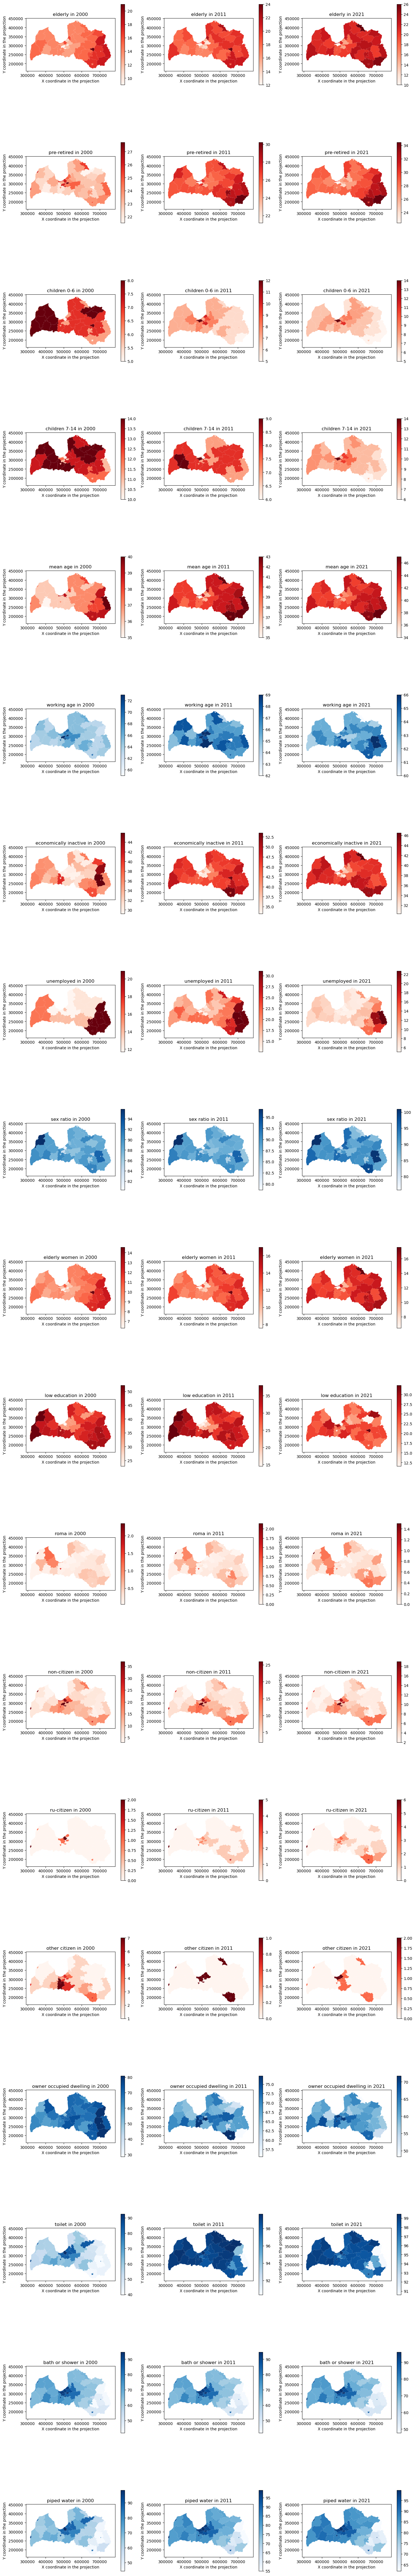

In [6]:
#Making a plot

from matplotlib.colors import Normalize #By using Normalize, the color representation for each subplot is made consistent.
                                        #For example, a particular shade of red represents the same value range across all subplots,
                                        #regardless of the actual minimum and maximum data values in each subplot. 
                                        #This makes it easier to visually compare different plots without getting misled by varying color scales.
num_columns = len(years)
num_rows = len(variables_gdfs)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows), squeeze=False)

for row_idx, (variable, variable_gdf) in enumerate(variables_gdfs.items()): #Making sure each plot has its own min and max value on the lengend
    cmap = 'Reds' if variable_gdf['vulnerability'].iloc[0] == 'increases' else 'Blues'
    for col_idx, year in enumerate(years):
        ax = axes[row_idx, col_idx]  
        vmin = variable_gdf[year].min()  # Minimum value for the colorbar
        vmax = variable_gdf[year].max()  # Maximum value for the colorbar

        variable_gdf.plot(
            column=year,
            ax=ax,
            legend=True,
            cmap= cmap,
            norm=Normalize(vmin=vmin, vmax=vmax),  #Normalizes data to the [0, 1] interval before it's mapped to colors using a colormap
            legend_kwds={'orientation': "vertical", 'shrink': 0.5}  
        )
        
        ax.set_title(f"{variable} in {year}")
        ax.set_xlabel('X coordinate in the projection')
        ax.set_ylabel('Y coordinate in the projection')

plt.tight_layout() 
plt.show()

# Preparation for Further Analysis

**Pivoting the tables.** 

Pivoting helps to get the dataset for each year, where all variables for all locations are represented.
This part of the code reformats the initial dataframe into dataframes holding variables for each year separately.

In [7]:
years_list = [int(year) for year in years] #reformats strings from the inital column names into integers

variables_dfs_by_year = {} #creates dictionary where all CENSUS dataframes will be located

#Pivoting the table and dispalying each df
for year in years_list:
    # Pivots the table: rows are 'LAU name', columns are 'variable', and the cells contain data for a 'year'
    pivot_df = variables_df.pivot(index='LAU 2022', columns='variable', values=str(year))
    variables_dfs_by_year[year] = pivot_df
    
    # Displays the pivoted df
    print("")
    print(f"\nCENSUS dataset for the year {year}:")
    display(variables_dfs_by_year[year].head())
    print("")



CENSUS dataset for the year 2000:


variable,bath or shower,children 0-6,children 7-14,economically inactive,elderly,elderly women,low education,mean age,non-citizen,other citizen,owner occupied dwelling,piped water,pre-retired,roma,ru-citizen,sex ratio,toilet,unemployed,working age
LAU 2022,,,,,,,,,,,,,,,,,,,
Aizkraukles nov.,65.580131,7.0,13.0,31.045082,15.0,10.02,42.086146,37.0,11.0,2.0,66.158871,60.861466,23.28,0.221597,0.0,88.149016,53.696190,13.9,64.0
Alūksnes nov.,60.812454,8.0,14.0,39.735826,16.0,10.77,42.115920,37.0,6.0,1.0,73.605709,59.087446,22.20,0.140035,0.0,88.463928,45.439237,12.6,63.0
Augšdaugavas nov.,49.837456,6.0,12.0,38.823144,17.0,11.98,48.254272,39.0,15.0,4.0,71.878556,45.425158,23.82,0.456055,0.0,90.900512,40.940830,20.9,63.0
Balvu nov.,43.250760,7.0,13.0,44.292059,18.0,12.41,46.262952,39.0,5.0,1.0,80.122785,46.356780,23.21,0.414707,0.0,88.671241,43.024031,20.9,62.0
Bauskas nov.,71.633844,7.0,14.0,31.883377,13.0,8.92,45.779569,36.0,13.0,5.0,73.465649,71.869720,22.69,0.174822,0.0,89.599751,62.774555,13.9,66.0





CENSUS dataset for the year 2011:


variable,bath or shower,children 0-6,children 7-14,economically inactive,elderly,elderly women,low education,mean age,non-citizen,other citizen,owner occupied dwelling,piped water,pre-retired,roma,ru-citizen,sex ratio,toilet,unemployed,working age
LAU 2022,,,,,,,,,,,,,,,,,,,
Aizkraukles nov.,65.580131,6.0,8.0,45.757723,19.0,12.83,29.783436,41.0,8.0,0.0,71.541235,75.858353,27.33,0.223934,0.0,88.153622,99.180691,19.7,67.0
Alūksnes nov.,60.812454,6.0,8.0,46.871592,20.0,13.13,28.264722,41.0,4.0,0.0,59.265734,75.522987,26.12,0.000000,1.0,87.842111,99.586475,24.0,65.0
Augšdaugavas nov.,49.837456,6.0,7.0,52.881720,21.0,14.00,31.901500,43.0,13.0,1.0,77.185186,65.224283,28.66,0.609885,1.0,90.319441,98.590128,26.0,66.0
Balvu nov.,43.250760,6.0,8.0,49.359929,20.0,14.15,33.579996,42.0,4.0,0.0,68.255724,55.084460,27.86,0.398133,0.0,87.816405,94.227915,30.0,66.0
Bauskas nov.,71.633844,7.0,8.0,45.333601,17.0,11.57,33.929012,40.0,11.0,0.0,65.888748,81.684558,26.24,0.154976,0.0,89.899477,98.345931,21.5,69.0





CENSUS dataset for the year 2021:


variable,bath or shower,children 0-6,children 7-14,economically inactive,elderly,elderly women,low education,mean age,non-citizen,other citizen,owner occupied dwelling,piped water,pre-retired,roma,ru-citizen,sex ratio,toilet,unemployed,working age
LAU 2022,,,,,,,,,,,,,,,,,,,
Aizkraukles nov.,71.500337,7.0,8.0,43.384835,23.0,14.70,21.826150,44.0,6.0,0.0,63.463398,82.523631,29.39,0.2,0.0,91.916089,98.234114,9.0,63.0
Alūksnes nov.,67.795100,6.0,8.0,41.189390,23.0,15.11,29.940430,44.0,3.0,0.0,63.636364,83.496659,30.46,0.0,1.0,86.805930,99.005197,11.0,62.0
Augšdaugavas nov.,55.643254,5.0,6.0,44.606427,24.0,15.31,23.143354,46.0,10.0,1.0,66.676106,70.407686,33.66,0.7,3.0,98.431042,96.754146,13.6,65.0
Balvu nov.,48.811891,6.0,7.0,41.157965,22.0,14.84,20.602566,44.0,3.0,0.0,58.708052,62.042484,31.93,0.5,0.0,92.674030,90.592488,12.9,64.0
Bauskas nov.,76.446981,7.0,9.0,41.425632,20.0,12.68,26.158262,42.0,7.0,1.0,61.307564,86.374035,28.72,0.1,0.0,93.749710,98.079735,7.8,65.0


In [8]:
#Creates z_scores folder in the ouput folder
output_dir_variables_dfs_by_year = os.path.join("output","variables_dfs_by_year")
os.makedirs(output_dir_variables_dfs_by_year, exist_ok=True)
print(f"Output directory {'already exists' if os.path.exists(output_dir_variables_dfs_by_year) else 'created'}.")

Output directory already exists.


In [9]:
#Saves the pivoted datasets into the folder
for year, variables_df_by_year in variables_dfs_by_year.items():
    output_path = os.path.join(output_dir_variables_dfs_by_year, f"variables_df_{year}.csv")
    variables_df_by_year.to_csv(output_path, encoding='utf-8-sig')
    print(f"Saved normalized DataFrame for the year {year} to {output_path}")

Saved normalized DataFrame for the year 2000 to output\variables_dfs_by_year\variables_df_2000.csv
Saved normalized DataFrame for the year 2011 to output\variables_dfs_by_year\variables_df_2011.csv
Saved normalized DataFrame for the year 2021 to output\variables_dfs_by_year\variables_df_2021.csv


# Contributors

Institute for Environmental Studies (IVM) (the Netherlands).

Authors of the workflow: Alona Bogdanova